In [1]:
import cv2
import numpy as np
import os
import math
from src.our_chessboard_detection import *
from matplotlib import pyplot as plt

dataDir = 'images' # Change this, according to your images' directory path

In [2]:
# Open image
image = cv2.imread(os.path.join(dataDir, 'G078_IMG092.jpg')) # Change this, according to your image's path

cv2.imshow("Image", image)

cv2.waitKey(0)
cv2.destroyAllWindows()

2025-04-10 15:48:30.159 Python[6859:11850443] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-10 15:48:30.159 Python[6859:11850443] +[IMKInputSession subclass]: chose IMKInputSession_Modern


### applying different filters

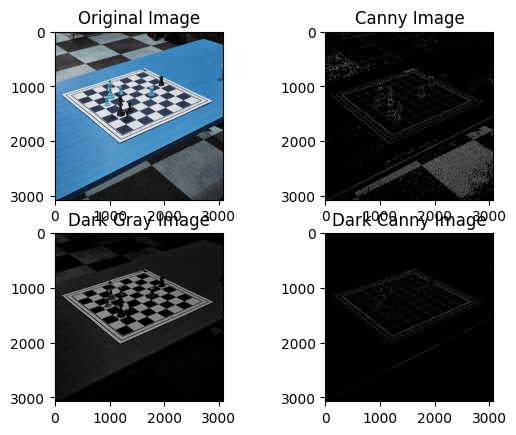

In [3]:

filtered_images = apply_filters(image, True)


### Detecting chessboard

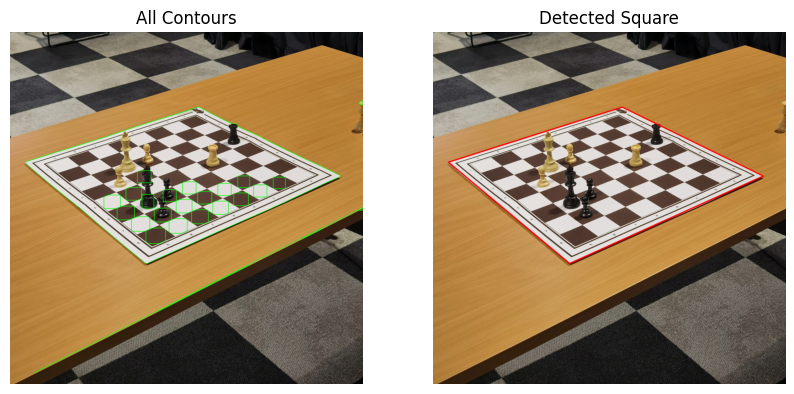

In [4]:
chess_contour = get_contours(filtered_images, show=True,  kernel_size=(25,25) ,  kernel_usage=True, iterations=4)


### rotate and warp

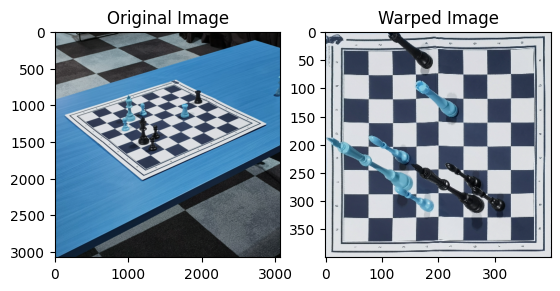

In [5]:
warped_image = rotate_and_crop(filtered_images, chess_contour[0][1], show=True)

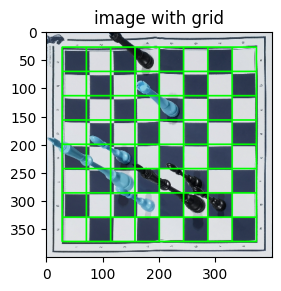

In [6]:
chesboard_grids(warped_image, show = True)